In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 22.2 MB/s eta 0:00:0000:01


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

In [6]:
# Set a random seed to ensure reproducibility
np.random.seed(12345)

In [7]:
%matplotlib inline

In [8]:
# Install and set up the wandb package (for tracking machine learning experiments)
!pip install wandb

In [9]:
!python -m wandb --version

python -m wandb, version 0.18.3


In [10]:
!wandb disabled

W&B disabled.


In [11]:
# Define file paths for input and working directories
Input_path = "/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data"
Work_path = '/kaggle/working'

In [12]:
# Define the number of classes and their labels for the safety gear detection task
num_classes= 11
classes = ['Gloves', 'Hardhat', 'Mask', 'NO-Gloves', 'NO-Hardhat', 'NO-Mask',
           'NO-Safety Boot', 'NO-Safety Vest', 'Person', 'Safety Boot', 'Safety Vest']

In [13]:
# Create a dictionary to map class indices to class names
class_idx = {str(i): classes[i] for i in range(num_classes)}
class_idx

{'0': 'Gloves',
 '1': 'Hardhat',
 '2': 'Mask',
 '3': 'NO-Gloves',
 '4': 'NO-Hardhat',
 '5': 'NO-Mask',
 '6': 'NO-Safety Boot',
 '7': 'NO-Safety Vest',
 '8': 'Person',
 '9': 'Safety Boot',
 '10': 'Safety Vest'}

In [14]:
# Define a YAML dictionary to store dataset paths and class information
dict_file = {
    'train': os.path.join(Input_path, 'train'),
    'val': os.path.join(Input_path, 'valid'),
    'test': os.path.join(Input_path, 'test'),
    'nc': num_classes,
    'names': classes
}

In [15]:
# Write the configuration to a YAML file
with open(os.path.join(Work_path, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [16]:
# Initialize dictionaries to store class statistics and dataset lengths
class_stat = {}
data_len = {}

# Loop over the datasets: 'train', 'valid', and 'test'

for mode in ['train', 'valid', 'test']:
    # Initialize class counts for each dataset
    class_count = {classes[i]: 0 for i in range(num_classes)}
    path = os.path.join(Input_path, mode, 'labels')  # Path to labels

    # Loop through each label file to count the instances of each class

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()
            for cls in set([line.split()[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    # Store the dataset length and class statistics

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

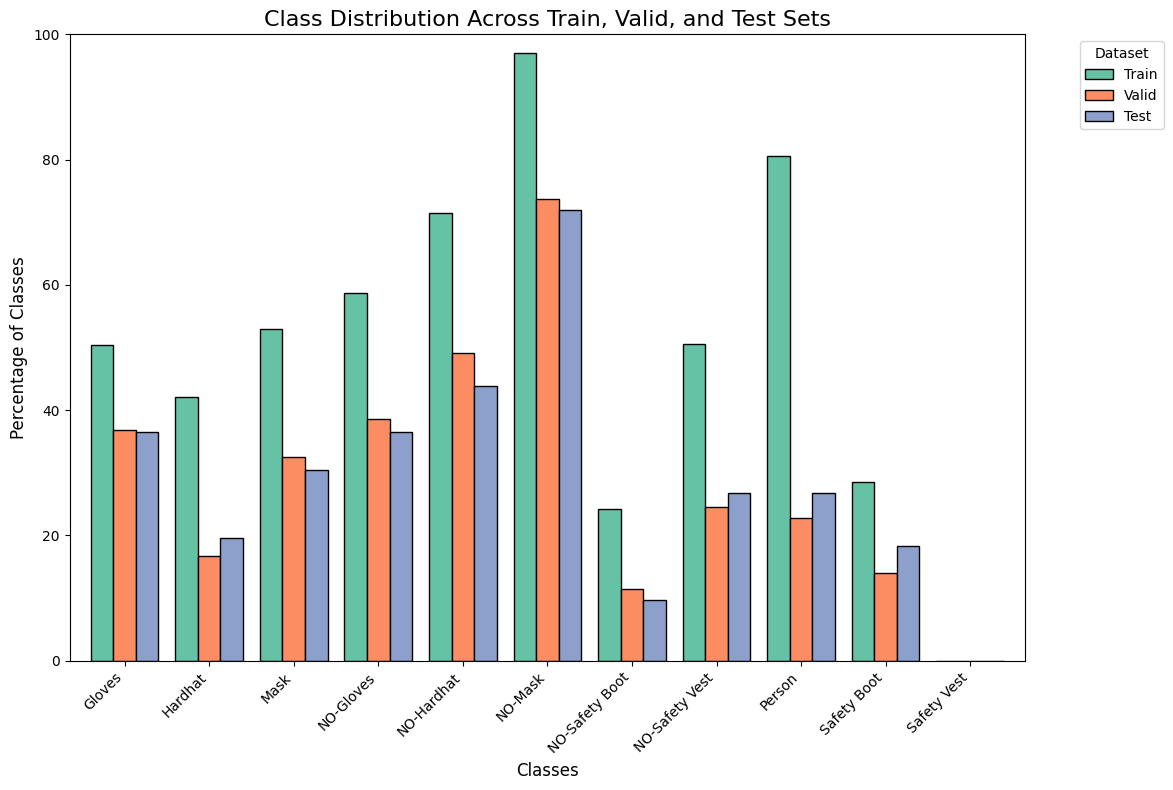

In [17]:
# Set up the color palette for class visualization
colors = sns.color_palette("Set2", num_classes)


# Initialize a figure for plotting the class distributions
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate the class distribution percentages for each dataset (train, valid, test)
df_train = pd.DataFrame({'train': class_stat['train']}) / data_len['train'] * 100
df_valid = pd.DataFrame({'valid': class_stat['valid']}) / data_len['valid'] * 100
df_test = pd.DataFrame({'test': class_stat['test']}) / data_len['test'] * 100

# Combine all datasets into a single DataFrame for grouped bar plotting
df_combined = pd.concat([df_train, df_valid, df_test], axis=1)

# Plot the class distribution as a grouped bar chart
df_combined.plot(kind='bar', ax=ax, color=colors, edgecolor="black", width=0.8)

# Set the plot title and axis labels
ax.set_title('Class Distribution Across Train, Valid, and Test Sets', fontsize=16)
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Percentage of Classes', fontsize=12)
ax.set_ylim(0, 100)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(classes, rotation=45, ha='right')

# Add a legend to the plot, showing dataset names
plt.legend(['Train', 'Valid', 'Test'], bbox_to_anchor=(1.05, 1), loc='upper left', title="Dataset")

# Adjust layout to ensure the plot fits well
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


In [18]:
# Print image sizes in each dataset(train, valid, test)
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(Input_path, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in valid set:

	(640, 640)

Image sizes in test set:

	(640, 640)


In [19]:
# Print the number of images in each dataset
for mode in ['train', 'valid', 'test']:
    files = glob.glob(os.path.join(Input_path, mode, 'images', '*'))
    print(f'{mode} set size: {len(files)}\n')

train set size: 2605

valid set size: 114

test set size: 82



# Milestone2

In [20]:
!pip install torch torchvision

In [21]:
import torch
from ultralytics import YOLO
import os

# Define paths for input and working directories
input_path = "/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data"
work_path = '/kaggle/working'

In [22]:
# Load a pre-trained YOLOv5 model
model = YOLO('yolov8n.pt')  # Use YOLOv5 small variant for faster results

100%|██████████| 6.25M/6.25M [00:00<00:00, 110MB/s]


In [23]:
# Define a YAML configuration file
data_yaml_path = os.path.join(work_path, 'data.yaml')  # Path to your data.yaml file

In [24]:
import os

# List the contents of the dataset directory
input_path = "/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data"
print(os.listdir(input_path))

['README.dataset.txt', 'README.roboflow.txt', 'valid', 'test', 'train']


In [25]:
train:"/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images"
val: "/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/images"
test: "/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images" # Optional if a test set exists

nc: 11
names: ['Gloves', 'Hardhat', 'Mask', 'NO-Gloves', 'NO-Hardhat', 'NO-Mask', 
        'NO-Safety Boot', 'NO-Safety Vest', 'Person', 'Safety Boot', 'Safety Vest']


In [71]:
import yaml

# Define the dictionary with updated class information
dict_file = {
    'train': '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images',
    'val': '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/images',
    'test': '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images',  # Optional
    'nc': 11,
    'names': ['Gloves', 'Hardhat', 'Mask', 'NO-Gloves', 'NO-Hardhat', 'NO-Mask',
              'NO-Safety Boot', 'NO-Safety Vest', 'Person', 'Safety Boot', 'Safety Vest']
}

# Save the YAML configuration file
data_yaml_path = '/kaggle/working/data.yaml'
with open(data_yaml_path, 'w') as file:
    yaml.dump(dict_file, file)

print(f"YAML file successfully saved at: {data_yaml_path}")


YAML file successfully saved at: /kaggle/working/data.yaml


In [43]:
model.train(
    data=data_yaml_path,      # Path to your data.yaml file
    epochs=100,               # Increase epochs to ensure better learning
    batch=32,                 # Adjust batch size based on GPU memory
    imgsz=640,                # Image size
    lr0=0.01,                 # Initial learning rate
    lrf=0.1,                  # Final learning rate (one-cycle learning rate policy)
    momentum=0.937,           # Momentum for SGD optimizer
    weight_decay=0.0005,      # Regularization to reduce overfitting
    warmup_epochs=3,          # Gradually increase the learning rate in the first 3 epochs
    warmup_momentum=0.8,      # Momentum during warmup
    warmup_bias_lr=0.1,       # Learning rate for bias during warmup
    optimizer='Adam',         # Use Adam optimizer for better convergence
    patience=50,              # Early stopping patience
    augment=True,             # Enable data augmentation
    mosaic=1.0,               # Mosaic augmentation (value between 0.0 to 1.0)
    mixup=0.2,                # MixUp augmentation
    close_mosaic=10,          # Disable mosaic augmentation after 10 epochs
    hsv_h=0.015,              # Augmentation for color space (hue)
    hsv_s=0.7,                # Saturation augmentation
    hsv_v=0.4,                # Value (brightness) augmentation
    perspective=0.0,          # Perspective augmentation
    translate=0.1,            # Translation augmentation
    scale=0.5,                # Scaling augmentation
    fliplr=0.5,               # Horizontal flip probability
    cache=True,               # Cache dataset to speed up training
    device=0,                 # Specify GPU (0 for first GPU)
    save_period=5,            # Save model every 5 epochs
    val=True                  # Run validation after each epoch
)


Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolov8n.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=5, cache=True, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:03<00:00, 651.99it/s]

train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train is not writeable, cache not saved.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (3.0GB RAM): 100%|██████████| 2605/2605 [00:04<00:00, 626.69it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 363.66it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 114/114 [00:00<00:00, 222.61it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.51G       1.94      2.769      1.939        390        640: 100%|██████████| 82/82 [00:28<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all        114        697        0.4      0.101     0.0496     0.0175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.59G       1.59      2.174        1.7        231        640: 100%|██████████| 82/82 [00:27<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all        114        697      0.348      0.262      0.209     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.44G       1.52      2.026      1.652        369        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all        114        697      0.218      0.168      0.123     0.0555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.79G      1.492      1.964      1.634        248        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all        114        697      0.444      0.305      0.289      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.49G      1.444      1.872      1.597        265        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all        114        697      0.382      0.279      0.265      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       6.2G      1.416      1.778      1.568        331        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all        114        697      0.498       0.27      0.283      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.72G      1.394      1.744      1.557        362        640: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all        114        697       0.59      0.337      0.356       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       5.6G      1.369      1.707      1.547        339        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all        114        697      0.579      0.338      0.374      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.42G       1.36      1.664      1.537        357        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all        114        697       0.54      0.428      0.431      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.72G      1.314      1.588        1.5        350        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all        114        697      0.599      0.389      0.417      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.68G      1.314      1.574      1.498        239        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all        114        697      0.525      0.405        0.4      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.59G      1.281      1.529      1.468        291        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all        114        697      0.636      0.395      0.431      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.88G      1.285      1.512      1.479        410        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all        114        697      0.588      0.382      0.418      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.87G       1.28      1.509      1.478        223        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all        114        697      0.703      0.392      0.464      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.98G      1.241       1.44      1.443        258        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all        114        697      0.727      0.384      0.462      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.43G      1.242       1.45      1.451        259        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all        114        697      0.655      0.392       0.42      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.07G      1.231      1.433      1.438        300        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all        114        697      0.717      0.433      0.506      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.85G      1.218      1.393      1.425        300        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all        114        697      0.673      0.418      0.467      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.21G      1.218      1.401       1.43        289        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all        114        697      0.708      0.384      0.451      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       5.7G        1.2      1.357      1.408        336        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all        114        697      0.678      0.449      0.491       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       6.5G       1.19      1.351       1.41        293        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all        114        697      0.659      0.424      0.451      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.18G      1.168      1.333      1.398        314        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all        114        697      0.662      0.438      0.468      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.23G       1.18      1.334      1.397        246        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all        114        697      0.651      0.445      0.484      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.99G       1.16      1.309      1.383        351        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all        114        697       0.65      0.433      0.476       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.81G      1.173      1.307      1.391        338        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all        114        697      0.686      0.464      0.502      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.53G      1.161      1.289      1.381        223        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all        114        697      0.712      0.445      0.519      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.57G      1.142      1.283      1.375        382        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all        114        697      0.685      0.447        0.5       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.84G      1.126       1.25       1.36        303        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all        114        697      0.728      0.449      0.494      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.99G      1.127      1.253      1.365        285        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all        114        697      0.672      0.471       0.51      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.94G      1.119      1.243      1.358        296        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all        114        697      0.695      0.468      0.512      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       6.1G      1.109      1.215      1.345        355        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all        114        697      0.645      0.464      0.497      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.72G      1.103      1.219      1.346        400        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all        114        697      0.733      0.455      0.519       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.09G      1.105      1.215       1.35        295        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all        114        697      0.782      0.482      0.539      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.58G      1.114      1.215       1.35        240        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all        114        697      0.744      0.466      0.535      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.16G       1.11      1.208      1.343        226        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all        114        697      0.753      0.464      0.527      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.49G       1.11      1.209      1.349        264        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all        114        697      0.764      0.477      0.545      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.41G      1.079      1.183      1.327        293        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all        114        697      0.648       0.47      0.515      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       6.7G      1.092      1.196      1.337        315        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all        114        697      0.752      0.489      0.536      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.94G      1.083      1.172      1.328        459        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all        114        697      0.678      0.497      0.515       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.85G      1.058      1.145       1.31        244        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all        114        697      0.726       0.51      0.545      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.29G      1.073      1.178      1.327        323        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all        114        697      0.677      0.499      0.526      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.62G      1.057      1.136       1.31        391        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all        114        697      0.743      0.493      0.538       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.75G      1.067      1.144       1.32        221        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all        114        697      0.712      0.469      0.529      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.41G      1.066      1.148      1.318        280        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all        114        697      0.763      0.494      0.549      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.47G      1.048      1.123      1.306        206        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all        114        697      0.733      0.486      0.534      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.93G      1.039      1.098      1.292        308        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all        114        697      0.662      0.511       0.54      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.23G      1.036      1.107      1.294        273        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all        114        697      0.766      0.491      0.555      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.5G      1.023      1.096       1.29        424        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all        114        697      0.716      0.521      0.554      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.91G      1.025      1.097       1.29        300        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all        114        697      0.765       0.49      0.554      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.51G      1.023      1.081       1.29        214        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all        114        697      0.767      0.514      0.568      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.3G       1.01      1.066      1.278        285        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all        114        697        0.7      0.516       0.55      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.11G      1.023      1.091      1.288        207        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all        114        697      0.705      0.533      0.569      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.73G      1.008      1.076      1.277        278        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all        114        697      0.758      0.523      0.575      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.31G     0.9964      1.043      1.266        282        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all        114        697      0.756      0.512      0.577      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.56G      1.021      1.091      1.287        354        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all        114        697      0.813      0.459      0.544      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.14G      1.022      1.079      1.288        335        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all        114        697      0.775      0.509      0.576      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.29G     0.9967      1.047      1.267        418        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all        114        697      0.744      0.535      0.568      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         6G      1.002      1.071      1.274        299        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all        114        697      0.791      0.521       0.58      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.47G     0.9868      1.027      1.259        212        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all        114        697      0.715      0.537      0.588      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.07G     0.9905      1.039      1.268        309        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all        114        697      0.752       0.54      0.574      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.49G      0.989      1.036      1.262        372        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all        114        697       0.77      0.522      0.591      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.98G     0.9708      1.023      1.255        248        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all        114        697      0.796      0.511      0.597      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.52G     0.9746      1.017      1.254        264        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all        114        697      0.784      0.506      0.586      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.59G     0.9632     0.9999      1.241        295        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all        114        697      0.752      0.506      0.581      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.55G     0.9578      0.997      1.243        301        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all        114        697      0.764      0.503      0.588      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.77G     0.9561     0.9843      1.236        233        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all        114        697      0.817      0.513        0.6      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.88G     0.9501     0.9839      1.237        289        640: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all        114        697      0.792      0.492      0.574      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.59G     0.9526     0.9827       1.24        314        640: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all        114        697      0.816      0.529      0.613       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.13G     0.9488     0.9812      1.238        315        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all        114        697      0.745      0.573      0.622      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.98G      0.961     0.9991      1.242        394        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all        114        697      0.801      0.521      0.592       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.32G      0.954     0.9881      1.243        374        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all        114        697       0.79      0.557      0.614      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.48G     0.9257     0.9529      1.215        376        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all        114        697      0.763      0.566      0.617      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.82G     0.9356     0.9663       1.23        195        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all        114        697      0.785       0.55      0.611      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       6.1G     0.9332     0.9611       1.23        284        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all        114        697      0.752       0.55      0.607      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.15G     0.9255     0.9639      1.225        314        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all        114        697      0.756      0.557      0.622      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.94G     0.9252     0.9466       1.22        323        640: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all        114        697      0.754      0.531      0.586      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.15G     0.9214     0.9525      1.222        351        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all        114        697      0.841      0.514      0.606      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.46G     0.9209     0.9492      1.219        311        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all        114        697      0.776      0.562      0.614      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       6.5G     0.9162     0.9356      1.216        296        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all        114        697      0.832      0.554       0.62      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.44G     0.9106     0.9427      1.217        291        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all        114        697      0.796      0.571      0.618       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.06G     0.9046     0.9357      1.211        416        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all        114        697      0.803      0.545      0.616      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.62G     0.8941      0.907      1.198        345        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all        114        697      0.808      0.552      0.618      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.13G     0.8856     0.9141        1.2        231        640: 100%|██████████| 82/82 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all        114        697      0.788      0.551      0.611      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.14G     0.8814     0.8986      1.194        236        640: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all        114        697      0.814      0.561      0.631      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.47G     0.8769     0.8903      1.187        407        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all        114        697      0.831      0.551      0.635      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.26G     0.8699     0.8879      1.189        253        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all        114        697      0.815      0.548      0.627      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.26G     0.8753     0.8959      1.191        258        640: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all        114        697      0.783      0.589      0.643      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.51G     0.8694     0.8811      1.187        331        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all        114        697      0.829      0.552      0.638      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.71G      0.855      0.867      1.179        200        640: 100%|██████████| 82/82 [00:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all        114        697      0.811      0.571      0.641      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.46G     0.8569      0.875       1.18        314        640: 100%|██████████| 82/82 [00:27<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all        114        697      0.817      0.546       0.63      0.327


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.44G      1.138      1.115      1.362        108        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all        114        697      0.867      0.555      0.656      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.92G      1.095      1.018      1.324        172        640: 100%|██████████| 82/82 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all        114        697      0.778      0.607      0.654      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.58G      1.071     0.9832      1.303        212        640: 100%|██████████| 82/82 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all        114        697       0.83      0.591      0.666      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.38G      1.042     0.9401      1.286        168        640: 100%|██████████| 82/82 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all        114        697      0.814       0.61      0.675      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.85G      1.042     0.9232      1.274        209        640: 100%|██████████| 82/82 [00:26<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all        114        697      0.833      0.604      0.684      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.79G      1.027     0.9108      1.264        193        640: 100%|██████████| 82/82 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all        114        697      0.854      0.599      0.686      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.14G       1.01     0.8817      1.254        172        640: 100%|██████████| 82/82 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all        114        697      0.835      0.623      0.699      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.99G          1     0.8678      1.249        173        640: 100%|██████████| 82/82 [00:26<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all        114        697      0.841      0.633      0.703      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.69G     0.9908     0.8502       1.24        126        640: 100%|██████████| 82/82 [00:26<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all        114        697      0.829      0.625      0.702      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.82G     0.9764     0.8323      1.231        151        640: 100%|██████████| 82/82 [00:26<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all        114        697      0.864      0.606      0.706      0.394



100 epochs completed in 0.817 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.3MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


                   all        114        697      0.849      0.634      0.706      0.414
                Gloves         42         79       0.92      0.727      0.815      0.504
               Hardhat         19         21       0.95      0.857      0.858      0.566
                  Mask         37         69      0.939      0.507      0.618      0.324
             NO-Gloves         44         74      0.825      0.509      0.593      0.275
            NO-Hardhat         56        106      0.787      0.575      0.659      0.369
               NO-Mask         84        166      0.868      0.657      0.752      0.443
        NO-Safety Boot         13         44      0.859      0.727      0.772      0.422
        NO-Safety Vest         28         41      0.745      0.707       0.77      0.515
                Person         26         55      0.773      0.745      0.794      0.477
           Safety Boot         16         42       0.82      0.325      0.431      0.244
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c0694165840>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [49]:
# Validate the model's performance on the test set
results = model.val(data=data_yaml_path)

Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 737.10it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 114/114 [00:00<00:00, 506.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


                   all        114        697      0.848      0.635      0.709      0.414
                Gloves         42         79      0.911      0.722      0.815      0.503
               Hardhat         19         21      0.948      0.857      0.858      0.566
                  Mask         37         69      0.938      0.507      0.625      0.326
             NO-Gloves         44         74      0.826      0.512      0.593      0.274
            NO-Hardhat         56        106      0.787      0.575      0.658      0.367
               NO-Mask         84        166      0.882      0.663      0.758      0.444
        NO-Safety Boot         13         44      0.894       0.75      0.801      0.428
        NO-Safety Vest         28         41      0.744      0.707      0.768       0.51
                Person         26         55      0.773      0.745      0.794      0.476
           Safety Boot         16         42       0.78       0.31      0.424      0.247
Speed: 0.5ms preproce

In [45]:
model.export(format='torchscript')  # Exports to the current working directory by default

Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 15, 8400) (6.0 MB)

TorchScript: starting export with torch 2.4.0...
TorchScript: export success ✅ 2.8s, saved as 'runs/detect/train3/weights/best.torchscript' (11.9 MB)

Export complete (3.2s)
Results saved to /kaggle/working/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.torchscript imgsz=640 data=/kaggle/working/data.yaml  
Visualize:       https://netron.app


'runs/detect/train3/weights/best.torchscript'

In [58]:
# Run inference on the image
image_path = '/kaggle/input/ppe-detection/data/images/grinder-hitachi-power-tool-flexible-162625.jpg'
inference_results = model(image_path)

# Loop through results if inference_results is a list of outputs
for result in inference_results:
    # Convert result to an image and show
    result_image = result.plot()  # Use `plot()` if available to overlay detections
    Image.fromarray(result_image).show()



image 1/1 /kaggle/input/ppe-detection/data/images/grinder-hitachi-power-tool-flexible-162625.jpg: 448x640 3 NO-Masks, 1 Person, 9.0ms
Speed: 3.3ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp5nd34tzw.PNG'



image 1/1 /kaggle/input/test31/download.jpeg: 384x640 2 persons, 24.9ms
Speed: 1.7ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


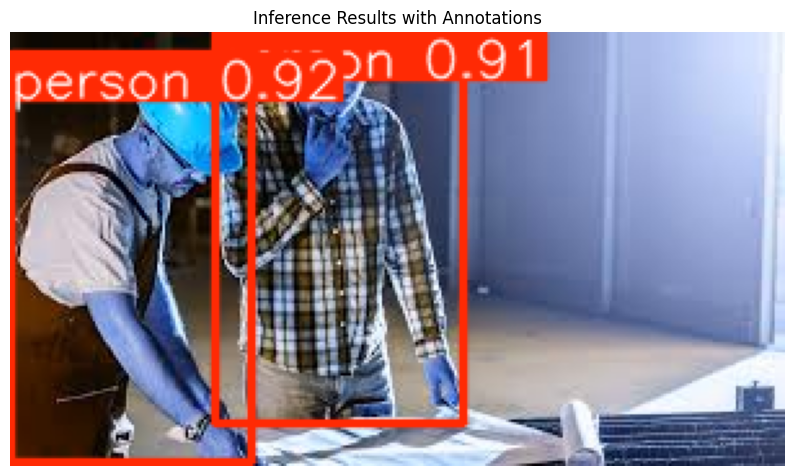

In [47]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to the image
image_path = '/kaggle/input/test31/download.jpeg'

# Run inference on the image
inference_results = model(image_path)

# Check if inference_results is a list, then plot each result
if isinstance(inference_results, list):
    for result in inference_results:
        # Convert result to an image with annotations
        annotated_img = result.plot()  # Make sure .plot() adds bounding boxes and labels
        annotated_img = Image.fromarray(annotated_img)

        # Show the annotated image using Matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(annotated_img)
        plt.axis("off")  # Hide axis for better visualization
        plt.title("Inference Results with Annotations")
        plt.show()
else:
    # If inference_results is not a list, display it directly
    annotated_img = inference_results.plot()
    annotated_img = Image.fromarray(annotated_img)

    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_img)
    plt.axis("off")
    plt.title("Inference Results with Annotations")
    plt.show()


# Milestone 3

In [51]:
from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO('/kaggle/working/runs/detect/train3/weights/best.pt')

In [73]:
import yaml  

# Define the dictionary with updated class information  
dict_file = {  
    'train': '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images',  
    'val': '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/images',  
    'test': '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images',  # Optional  
    'nc': 11,  # Number of classes  
    'names': ['Gloves', 'Hardhat', 'Mask', 'NO-Gloves', 'NO-Hardhat', 'NO-Mask',  
              'NO-Safety Boot', 'NO-Safety Vest', 'Person', 'Safety Boot', 'Safety Vest']  
}  

# Save the YAML configuration file for YOLO training and validation  
data_yaml_path = '/kaggle/working/data.yaml'  
with open(data_yaml_path, 'w') as file:  
    yaml.dump(dict_file, file)  # Write the dictionary to a YAML file  

print(f"YAML file successfully saved at: {data_yaml_path}")  


YAML file successfully saved at: /kaggle/working/data.yaml


In [74]:

# Evaluate the model using the validation dataset  
metrics = model.val(data=data_yaml_path, split='test')  

Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/labels... 82 images, 8 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<00:00, 742.76it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


                   all         82        760      0.799      0.606      0.665      0.378
                Gloves         30        110      0.953      0.734      0.871      0.508
               Hardhat         16         28          1      0.745        0.8      0.492
                  Mask         25         41      0.707      0.512      0.446      0.197
             NO-Gloves         30         79      0.766      0.494      0.566      0.271
            NO-Hardhat         36         90      0.915      0.597      0.708      0.376
               NO-Mask         59        174      0.796      0.693      0.756      0.413
        NO-Safety Boot          8         92      0.748      0.323      0.382      0.154
        NO-Safety Vest         22         61      0.666      0.705      0.774      0.499
                Person         22         44      0.681      0.795      0.814      0.534
           Safety Boot         15         41       0.76      0.465      0.531      0.332
Speed: 0.3ms preproce

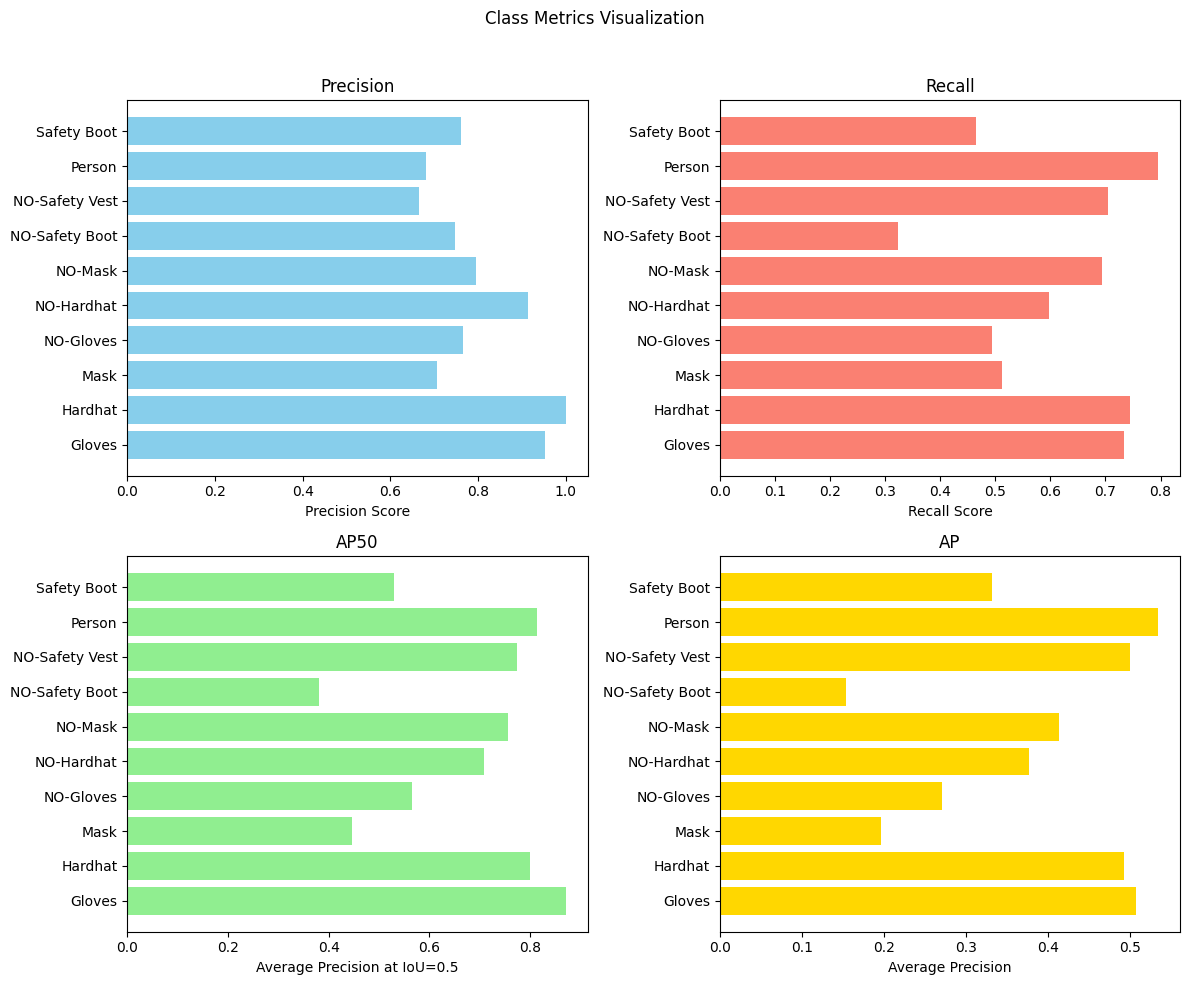

In [79]:
import matplotlib.pyplot as plt  
import numpy as np  

# Assuming metrics.names and metrics.class_result are defined and accessible  
num_classes = len(metrics.names) - 1  # Total number of classes (excluding the background)  

# Prepare lists to hold the values for plotting  
class_names = []  
precisions = []  
recalls = []  
ap50s = []  
aps = []  

# Collect metrics for each class  
for i in range(num_classes):  
    cls_name = metrics.names[i]  
    class_metrics = metrics.class_result(i)  

    # Extract metrics  
    class_precision = class_metrics[0]  
    class_recall = class_metrics[1]  
    class_ap50 = class_metrics[2]  
    class_ap = class_metrics[3]  

    # Store values in lists  
    class_names.append(cls_name)  
    precisions.append(class_precision)  
    recalls.append(class_recall)  
    ap50s.append(class_ap50)  
    aps.append(class_ap)  

# Convert lists to numpy arrays for easier plotting  
y = np.arange(num_classes)  

# Create a figure with multiple subplots  
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  
fig.suptitle('Class Metrics Visualization')  

# Precision  
axs[0, 0].barh(y, precisions, color='skyblue')  
axs[0, 0].set_yticks(y)  
axs[0, 0].set_yticklabels(class_names)  
axs[0, 0].set_title('Precision')  
axs[0, 0].set_xlabel('Precision Score')  

# Recall  
axs[0, 1].barh(y, recalls, color='salmon')  
axs[0, 1].set_yticks(y)  
axs[0, 1].set_yticklabels(class_names)  
axs[0, 1].set_title('Recall')  
axs[0, 1].set_xlabel('Recall Score')  

# AP50  
axs[1, 0].barh(y, ap50s, color='lightgreen')  
axs[1, 0].set_yticks(y)  
axs[1, 0].set_yticklabels(class_names)  
axs[1, 0].set_title('AP50')  
axs[1, 0].set_xlabel('Average Precision at IoU=0.5')  

# AP  
axs[1, 1].barh(y, aps, color='gold')  
axs[1, 1].set_yticks(y)  
axs[1, 1].set_yticklabels(class_names)  
axs[1, 1].set_title('AP')  
axs[1, 1].set_xlabel('Average Precision')  

# Adjust layout  
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the main title  
plt.show()

In [78]:
# Access precision, recall, mAP, and other metrics  
print(metrics.names)  # Inspect the names of the classes  

# Class-wise precision, recall, and F1-score  
num_classes = len(metrics.names ) -1 # Get the actual number of classes  
for i in range(num_classes):  # Iterate over the range of actual class indices  
    cls_name = metrics.names[i]  
    
    # Get metrics for the specific class  
    class_metrics = metrics.class_result(i)  

    # Assuming class_metrics returns a tuple or list in the order: [precision, recall, ap50, ap]  
    class_precision = class_metrics[0]  # Precision   
    class_recall = class_metrics[1]     # Recall  
    class_ap50 = class_metrics[2]       # AP50  
    class_ap = class_metrics[3]         # AP  

    print(f" '{i}' Class '{cls_name}': Precision={class_precision:.4f}, Recall={class_recall:.4f}, AP50={class_ap50:.4f}, AP={class_ap:.4f}")

{0: 'Gloves', 1: 'Hardhat', 2: 'Mask', 3: 'NO-Gloves', 4: 'NO-Hardhat', 5: 'NO-Mask', 6: 'NO-Safety Boot', 7: 'NO-Safety Vest', 8: 'Person', 9: 'Safety Boot', 10: 'Safety Vest'}
 '0' Class 'Gloves': Precision=0.9528, Recall=0.7339, AP50=0.8708, AP=0.5076
 '1' Class 'Hardhat': Precision=1.0000, Recall=0.7450, AP50=0.7999, AP=0.4923
 '2' Class 'Mask': Precision=0.7075, Recall=0.5122, AP50=0.4461, AP=0.1968
 '3' Class 'NO-Gloves': Precision=0.7664, Recall=0.4937, AP50=0.5664, AP=0.2708
 '4' Class 'NO-Hardhat': Precision=0.9149, Recall=0.5975, AP50=0.7078, AP=0.3764
 '5' Class 'NO-Mask': Precision=0.7955, Recall=0.6932, AP50=0.7560, AP=0.4132
 '6' Class 'NO-Safety Boot': Precision=0.7480, Recall=0.3227, AP50=0.3817, AP=0.1536
 '7' Class 'NO-Safety Vest': Precision=0.6660, Recall=0.7049, AP50=0.7741, AP=0.4993
 '8' Class 'Person': Precision=0.6808, Recall=0.7955, AP50=0.8135, AP=0.5341
 '9' Class 'Safety Boot': Precision=0.7604, Recall=0.4645, AP50=0.5305, AP=0.3317


In [76]:
model.predict(source='/kaggle/input/yolov8-finetuning-for-ppe-detection/runs/detect/predict/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg', save=True, save_txt=True)



image 1/1 /kaggle/input/yolov8-finetuning-for-ppe-detection/runs/detect/predict/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 1 Gloves, 1 NO-Gloves, 2 NO-Hardhats, 8 NO-Masks, 4 NO-Safety Vests, 3 Persons, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2
1 label saved to runs/detect/predict2/labels


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Gloves', 1: 'Hardhat', 2: 'Mask', 3: 'NO-Gloves', 4: 'NO-Hardhat', 5: 'NO-Mask', 6: 'NO-Safety Boot', 7: 'NO-Safety Vest', 8: 'Person', 9: 'Safety Boot', 10: 'Safety Vest'}
 obb: None
 orig_img: array([[[ 51,  47,  58],
         [ 72,  68,  79],
         [ 89,  85,  97],
         ...,
         [ 58,  44,  56],
         [ 49,  35,  47],
         [ 66,  52,  64]],
 
        [[ 49,  45,  56],
         [ 72,  68,  79],
         [ 90,  86,  98],
         ...,
         [ 53,  39,  51],
         [ 42,  28,  40],
         [ 69,  55,  67]],
 
        [[ 45,  41,  52],
         [ 72,  68,  79],
         [ 92,  88, 100],
         ...,
         [ 48,  34,  46],
         [ 42,  28,  40],
         [ 83,  69,  81]],
 
        ...,
 
        [[ 54,  56, 255],
         [ 59,  59, 249],
         [ 67,  66, 230],
         ...,
         [ 98, 108, 115],
 